In [6]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [7]:
os.listdir('./Dataset/train')

['Stewie Griffin', 'Peter Griffin', 'Brain Griffin', 'Lois Griffin']

In [8]:
training_dataset_path = './Dataset/train'
testing_dataset_path = './Dataset/test'

In [9]:
training_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [10]:
!nvidia-smi

Wed Jun  5 17:46:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8               3W /  35W |    188MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = False)

In [13]:
def get_mean_and_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [14]:
mean, std = get_mean_and_std(train_loader)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


/home/saksham/anaconda3/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([20, 3, 224, 224])


In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [16]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = testing_dataset_path, transform=test_transforms)

In [17]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))

    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.707473..1.4599121].


labels:  tensor([3, 0, 2, 0, 1, 0])


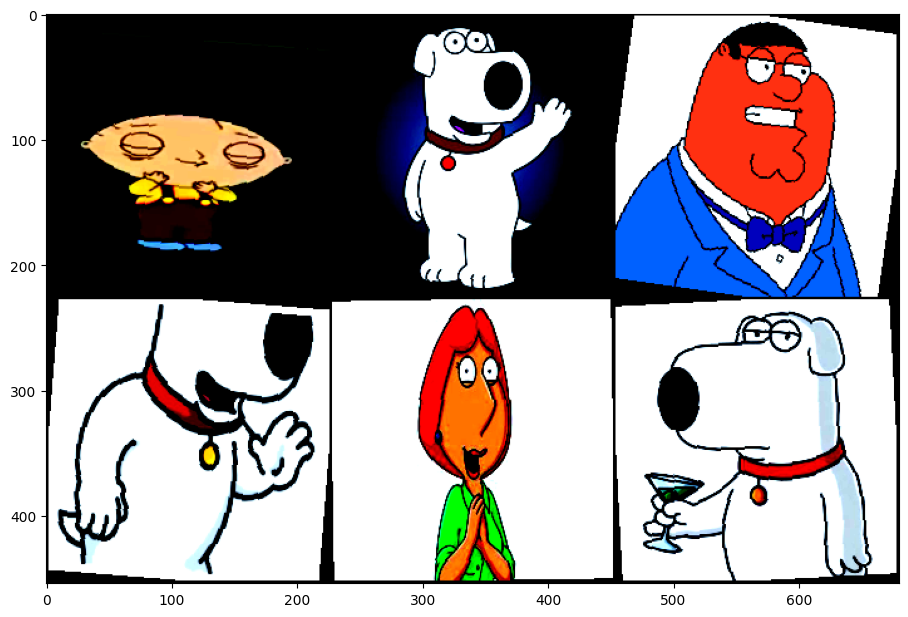

In [18]:
show_transformed_images(train_dataset)

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, shuffle = False)

In [20]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'

    return torch.device(dev)

In [21]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0


    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch+1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()


            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.0 * running_correct/total
        print("   -Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f " % (running_correct, total, epoch_acc, epoch_loss))
        test_acc = evaluate_model_on_test_set(model, test_loader)

        if (test_acc > best_acc) : 
            best_acc = test_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
    print("Finished")
    return model



In [22]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch':epoch + 1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'comment': "very cool model"
        }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [23]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted==labels).sum().item()
    epoch_acc = 100.0 * predicted_correctly_on_epoch/total
    print("   -Testing Dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))

    return epoch_acc


In [24]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet = models.resnet18(pretrained = False)
num_ftrs = resnet.fc.in_features
num_cls = 4
resnet.fc = nn.Linear(num_ftrs, num_cls)
device = set_device()
resnet_model = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

/home/saksham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saksham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [104]:
train_nn(resnet, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch number 1 
   -Training Dataset. Got 279 out of 660 images correctly (42.273%). Epoch loss: 1.231 
   -Testing Dataset. Got 12 out of 43 images correctly (27.907%)
Epoch number 2 
   -Training Dataset. Got 391 out of 660 images correctly (59.242%). Epoch loss: 0.961 
   -Testing Dataset. Got 28 out of 43 images correctly (65.116%)
Epoch number 3 
   -Training Dataset. Got 518 out of 660 images correctly (78.485%). Epoch loss: 0.619 
   -Testing Dataset. Got 16 out of 43 images correctly (37.209%)
Epoch number 4 
   -Training Dataset. Got 536 out of 660 images correctly (81.212%). Epoch loss: 0.517 
   -Testing Dataset. Got 41 out of 43 images correctly (95.349%)
Epoch number 5 
   -Training Dataset. Got 559 out of 660 images correctly (84.697%). Epoch loss: 0.518 
   -Testing Dataset. Got 40 out of 43 images correctly (93.023%)
Epoch number 6 
   -Training Dataset. Got 557 out of 660 images correctly (84.394%). Epoch loss: 0.438 
   -Testing Dataset. Got 29 out of 43 images correc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet = models.resnet18(pretrained = True)
num_ftrs = resnet.fc.in_features
num_cls = 4
resnet.fc = nn.Linear(num_ftrs, num_cls)
device = set_device()
resnet_model = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

/home/saksham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [106]:
train_nn(resnet, train_loader, test_loader, loss_fn, optimizer, 5)

Epoch number 1 
   -Training Dataset. Got 546 out of 660 images correctly (82.727%). Epoch loss: 0.454 
   -Testing Dataset. Got 43 out of 43 images correctly (100.000%)
Epoch number 2 
   -Training Dataset. Got 648 out of 660 images correctly (98.182%). Epoch loss: 0.044 
   -Testing Dataset. Got 43 out of 43 images correctly (100.000%)
Epoch number 3 
   -Training Dataset. Got 649 out of 660 images correctly (98.333%). Epoch loss: 0.041 
   -Testing Dataset. Got 43 out of 43 images correctly (100.000%)
Epoch number 4 
   -Training Dataset. Got 658 out of 660 images correctly (99.697%). Epoch loss: 0.015 
   -Testing Dataset. Got 43 out of 43 images correctly (100.000%)
Epoch number 5 
   -Training Dataset. Got 660 out of 660 images correctly (100.000%). Epoch loss: 0.004 
   -Testing Dataset. Got 43 out of 43 images correctly (100.000%)
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [26]:
print(checkpoint['epoch'])
print(checkpoint['comment'])
print(checkpoint['best_accuracy'])

1
very cool model
100.0


In [27]:
resnet = models.resnet18()
num_ftrs = resnet.fc.in_features
num_cls = 4
resnet.fc = nn.Linear(num_ftrs, num_cls)
resnet.load_state_dict(checkpoint['model'])

torch.save(resnet, 'best_model.pth')

In [28]:
import torchvision
import torch
import torchvision.transforms as transforms
import PIL.Image as Image

In [29]:
classes = [
    "Brain Griffin",
    "Lois Griffin", 
    "Peter Griffin",
    "Stewie Griffin"
]

In [30]:
model = torch.load('best_model.pth')

In [31]:
image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [32]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)

    output = model(image)
    _, predicted = torch.max(output.data, 1)

    print(predicted.item())
    


In [33]:
classify(resnet, image_transforms, '/home/saksham/Saksham/UAS/Software/TFG_char_classification/Dataset/test/Lois Griffin/Screenshot 2023-09-15 190632.png', classes)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0